# **Flight Delay Prediction using Scikit-Learn Pipeline**

## **Overview**
This project demonstrates how to build a **machine learning pipeline** using scikit-learn to predict flight delays. The pipeline integrates data preprocessing with model training, ensuring efficient handling of both numerical and categorical data.

---

## **Objectives**
- Preprocess numerical and categorical data using `ColumnTransformer`.
- Automate the machine learning workflow using `Pipeline`.
- Train a **Random Forest Classifier** to predict flight delays.
- Optimize the model using **GridSearchCV** for hyperparameter tuning.

---

## **Data Overview**
- **Dataset**: Contains flight details such as:
  - **Year**, **Month**, **Day**
  - **Airline code**, **Origin airport code**, **Destination airport code**
  - **Departure delay** (target: delayed or not)

- **Target Variable**:  
  - `1` if the flight was delayed  
  - `0` if the flight was on time

---

## **Steps Involved**

### 1. **Data Loading and Exploration**
- Load the flight dataset and inspect its structure and missing values.

### 2. **Feature Engineering**
- **Numerical Features**:
  - `YEAR`, `MONTH`, `DAY`
- **Categorical Features**:
  - `AIRLINE__CODE`, `ORIGIN_AIRPORT_CODE`, `DESTINATION_AIRPORT_CODE`

### 3. **Preprocessing with `ColumnTransformer`**
- **Numerical Data**:
  - Impute missing values with the **mean**.
  - Standardize values using **`StandardScaler`**.
  
- **Categorical Data**:
  - Impute missing values with `'missing'`.
  - Encode using **`OneHotEncoder`**.

### 4. **Pipeline Setup**
- Use a **scikit-learn Pipeline** to link preprocessing and model training.
- Integrate a **Random Forest Classifier** within the pipeline.

### 5. **Model Training and Evaluation**
- Split the data into **train (70%)** and **test (30%)** sets.
- Evaluate the model using a **classification report** with metrics like:
  - **Precision**, **Recall**, **F1-score**

### 6. **Hyperparameter Tuning with GridSearchCV**
- Tune hyperparameters of the Random Forest model:
  - Number of estimators (`n_estimators`)
  - Maximum tree depth (`max_depth`)

### 7. **Model Persistence**
- Save the trained model using **`joblib`** for later use.

---

## **Technologies Used**
- **Python**: Programming language
- **Pandas**: Data manipulation and cleaning
- **Scikit-Learn**: Machine learning, preprocessing, and model evaluation
- **Joblib**: Model persistence
- **Jupyter Notebook**: Interactive development environment

---

## **Expected Output**
- A **trained Random Forest model** to predict flight delays.
- **Performance metrics** (accuracy, precision, recall) from the classification report.
- A **saved model** (`flight_delay_classifier.pkl`) for deployment.

---

## **Conclusion**
This project demonstrates how to create an automated **machine learning workflow** using scikit-learn’s `Pipeline` and `ColumnTransformer`. The streamlined preprocessing ensures consistency during both training and testing. With **hyperparameter tuning**, the model's performance is further optimized, making it reliable for real-world flight delay predictions.


# Upgrade pip and install all required packages

In [ ]:
!pip install --upgrade pip

# Install Snowflake connectors, pandas integration, and essential libraries
!pip install "snowflake-connector-python[pandas]" \
             snowflake-snowpark-python==1.12.0,<2,>=1.11.1 \
             python-dateutil tqdm holidays faker
!pip install numpy pandas matplotlib scikit-learn xgboost seaborn \

# Ensure Snowpark Python is up-to-date
!pip install --upgrade -q snowflake-snowpark-python==1.12.0,<2,>=1.11.1


# Fix potential urllib3 version conflicts
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Additional installations for your project
!pip install fosforml==1.1.6
!pip install python-scipy
!pip install cloudpickle==2.2.1
!pip install basemap


# Importing necessary libraries and settings

In [1]:

# Standard libraries for date and warnings
import datetime
import warnings

# Scientific and Data Manipulation Libraries
import scipy
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# Sklearn Modules for Data Preprocessing, Modeling, and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Encoding categorical variables
from sklearn.preprocessing import StandardScaler  # Scaling numerical data
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.metrics import roc_auc_score, classification_report  # Evaluation metrics

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import configparser
from dateutil.relativedelta import relativedelta
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

# Configuring display options and warning filters
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

# Custom FosforML package for Snowflake session and model registration
from fosforml.model_manager.snowflakesession import get_session
from fosforml import register_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


In [2]:
# Set Matplotlib's default font family to 'DeJavu Serif' to ensure a consistent font style across plots
plt.rcParams['font.family'] = 'DeJavu Serif'

# Establishing a Snowflake session


In [3]:
my_session = get_session()

# Defining the table name to fetch data from
# table_name = 'FLIGHTS'  # Initial option for table
table_name = 'FLIGHTS_FULL'  # Final table to be used

# Querying the data from the specified Snowflake table
sf_df = my_session.sql("SELECT * FROM {}".format(table_name))

# Converting the Snowflake DataFrame to a pandas DataFrame for local processing
df = sf_df.to_pandas()

df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
0,2024,4,23,4,AA,1114,N3HTAA,LGA,DFW,1529,1542.0,13.0,18.0,1600.0,242.0,232.0,209.0,1389,1829.0,5.0,1831,1834.0,3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,American Airlines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720
1,2024,4,23,4,B6,813,N775JB,HPN,FLL,1529,1520.0,-9.0,15.0,1535.0,184.0,178.0,152.0,1097,1807.0,11.0,1833,1818.0,-15.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,JetBlue Airways,Westchester County Airport,White Plains,NY,USA,41.06696,-73.70757,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,USA,26.07258,-80.15275
2,2024,4,23,4,DL,1612,N942DL,ORD,ATL,1529,1529.0,0.0,11.0,1540.0,120.0,95.0,78.0,606,1758.0,6.0,1829,1804.0,-25.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Delta Air Lines Inc.,Chicago O'Hare International Airport,Chicago,IL,USA,41.97960,-87.90446,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694
3,2024,4,23,4,DL,1642,N906AT,ATL,CAK,1529,1526.0,-3.0,17.0,1543.0,104.0,102.0,80.0,528,1703.0,5.0,1713,1708.0,-5.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Akron-Canton Regional Airport,Akron,OH,USA,40.91631,-81.44247
4,2024,4,23,4,EV,4973,N931EV,ATL,GTR,1530,1528.0,-2.0,27.0,1555.0,69.0,75.0,45.0,241,1540.0,3.0,1539,1543.0,4.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Atlantic Southeast Airlines,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Golden Triangle Regional Airport,Columbus-Starkville-West Point,MS,USA,33.45033,-88.59137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2024,3,24,2,DL,1242,N949DL,LGA,PBI,1031,1029.0,-2.0,36.0,1105.0,194.0,183.0,144.0,1035,1329.0,3.0,1345,1332.0,-13.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559
5819075,2024,3,24,2,DL,1353,N904DE,ATL,PNS,1031,1031.0,0.0,9.0,1040.0,76.0,63.0,49.0,271,1029.0,5.0,1047,1034.0,-13.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Pensacola International Airport (Pensacola Gul...,Pensacola,FL,USA,30.47331,-87.18744
5819076,2024,3,24,2,DL,1544,N937DL,MSP,MSN,1031,1025.0,-6.0,18.0,1043.0,60.0,56.0,34.0,228,1117.0,4.0,1131,1121.0,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Delta Air Lines Inc.,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692,Dane County Regional Airport,Madison,WI,USA,43.13986,-89.33751
5819077,2024,3,24,2,F9,1183,N933FR,MDT,MCO,1031,1022.0,-9.0,22.0,1044.0,144.0,150.0,121.0,851,1245.0,7.0,1255,1252.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Frontier Airlines Inc.,Harrisburg International Airport,Harrisburg,PA,USA,40.19350,-76.76340,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603


# Filtering data for specific airlines

In [4]:
# Defining the list of airlines to include in the filtered DataFrame
#options = ['Southwest Airlines Co.', 'Delta Air Lines Inc.']
options = ['Southwest Airlines Co.']
#df.replace({'AIRLINE':'Southwest Airlines Co.'}, {'AIRLINE': 'Southwest airlines'}, regex=True)
#df.replace({'AIRLINE':'Delta Air Lines Inc.'}, {'AIRLINE': 'Delta airlines'}, regex=True)

# Selecting rows where the 'AIRLINE' column matches one of the specified airlines
flights = df.loc[df['AIRLINE'].isin(options)]
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
39,2024,4,23,4,WN,395,N7740A,LAS,SAN,1530,1555.0,25.0,26.0,1621.0,65.0,74.0,45.0,258,1706.0,3.0,1635,1709.0,34.0,0,0,None,9.0,0.0,5.0,20.0,0.0,2024-04-23,Southwest Airlines Co.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966
40,2024,4,23,4,WN,4989,N647SW,ATL,IND,1530,1531.0,1.0,18.0,1549.0,100.0,96.0,73.0,432,1702.0,5.0,1710,1707.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Indianapolis International Airport,Indianapolis,IN,USA,39.71733,-86.29438
41,2024,4,23,4,WN,1878,N8642E,SEA,DEN,1530,1537.0,7.0,13.0,1550.0,165.0,147.0,128.0,1024,1858.0,6.0,1915,1904.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,Denver International Airport,Denver,CO,USA,39.85841,-104.66700
42,2024,4,23,4,WN,300,N960WN,SMF,BUR,1530,1534.0,4.0,7.0,1541.0,65.0,60.0,50.0,358,1631.0,3.0,1635,1634.0,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,Bob Hope Airport (Hollywood Burbank Airport),Burbank,CA,USA,34.20062,-118.35850
43,2024,4,23,4,WN,573,N244WN,SMF,LAS,1530,1604.0,34.0,12.0,1616.0,80.0,77.0,61.0,397,1717.0,4.0,1650,1721.0,31.0,0,0,None,6.0,0.0,0.0,25.0,0.0,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819045,2024,3,24,2,WN,759,N236WN,PHX,CLE,1030,1043.0,13.0,23.0,1106.0,230.0,225.0,197.0,1737,1723.0,5.0,1720,1728.0,8.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806,Cleveland Hopkins International Airport,Cleveland,OH,USA,41.41089,-81.84940
5819046,2024,3,24,2,WN,566,N7727A,PHX,DTW,1030,1123.0,53.0,12.0,1135.0,230.0,209.0,191.0,1671,1746.0,6.0,1720,1752.0,32.0,0,0,None,0.0,0.0,12.0,20.0,0.0,2024-03-24,Southwest Airlines Co.,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
5819047,2024,3,24,2,WN,760,N7736A,OAK,BUR,1030,1028.0,-2.0,6.0,1034.0,65.0,56.0,46.0,325,1120.0,4.0,1135,1124.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,USA,37.72129,-122.22072,Bob Hope Airport (Hollywood Burbank Airport),Burbank,CA,USA,34.20062,-118.35850
5819048,2024,3,24,2,WN,336,N7748A,OAK,LAX,1030,1028.0,-2.0,10.0,1038.0,75.0,74.0,48.0,337,1126.0,16.0,1145,1142.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,USA,37.72129,-122.22072,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [5]:
flights = flights.dropna(subset = 'ARRIVAL_DELAY')

# Creating a copy of the filtered flights data

In [6]:
# This ensures that any modifications made to 'flights_needed_data' do not affect the original 'flights' DataFrame
flights_needed_data = flights.copy()

In [7]:
flights_needed_data.shape
#(2137736, 45)

(1242403, 45)

In [8]:
flights_needed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1242403 entries, 39 to 5819049
Data columns (total 45 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   YEAR                      1242403 non-null  int16  
 1   MONTH                     1242403 non-null  int8   
 2   DAY                       1242403 non-null  int8   
 3   DAY_OF_WEEK               1242403 non-null  int8   
 4   AIRLINE__CODE             1242403 non-null  object 
 5   FLIGHT_NUMBER             1242403 non-null  int16  
 6   TAIL_NUMBER               1242403 non-null  object 
 7   ORIGIN_AIRPORT_CODE       1242403 non-null  object 
 8   DESTINATION_AIRPORT_CODE  1242403 non-null  object 
 9   SCHEDULED_DEPARTURE       1242403 non-null  int16  
 10  DEPARTURE_TIME            1242403 non-null  float64
 11  DEPARTURE_DELAY           1242403 non-null  float64
 12  TAXI_OUT                  1242403 non-null  float64
 13  WHEELS_OFF                12424

In [9]:
flights_needed_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE
39,2024,4,23,4,WN,395,N7740A,LAS,SAN,1530,1555.0,25.0,26.0,1621.0,65.0,74.0,45.0,258,1706.0,3.0,1635,1709.0,34.0,0,0,None,9.0,0.0,5.0,20.0,0.0,2024-04-23,Southwest Airlines Co.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966
40,2024,4,23,4,WN,4989,N647SW,ATL,IND,1530,1531.0,1.0,18.0,1549.0,100.0,96.0,73.0,432,1702.0,5.0,1710,1707.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Indianapolis International Airport,Indianapolis,IN,USA,39.71733,-86.29438
41,2024,4,23,4,WN,1878,N8642E,SEA,DEN,1530,1537.0,7.0,13.0,1550.0,165.0,147.0,128.0,1024,1858.0,6.0,1915,1904.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,Denver International Airport,Denver,CO,USA,39.85841,-104.66700
42,2024,4,23,4,WN,300,N960WN,SMF,BUR,1530,1534.0,4.0,7.0,1541.0,65.0,60.0,50.0,358,1631.0,3.0,1635,1634.0,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,Bob Hope Airport (Hollywood Burbank Airport),Burbank,CA,USA,34.20062,-118.35850
43,2024,4,23,4,WN,573,N244WN,SMF,LAS,1530,1604.0,34.0,12.0,1616.0,80.0,77.0,61.0,397,1717.0,4.0,1650,1721.0,31.0,0,0,None,6.0,0.0,0.0,25.0,0.0,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233


# Function to categorize scheduled arrival times into time segments

In [10]:
def categorize_time(SCHEDULED_ARRIVAL):
    # Categorize based on scheduled arrival time in 24-hour format
    if 500 <= SCHEDULED_ARRIVAL < 800:
        return 'Early morning'
    elif 800 <= SCHEDULED_ARRIVAL < 1100:
        return 'Late morning'
    elif 1100 <= SCHEDULED_ARRIVAL < 1400:
        return 'Around noon'
    elif 1400 <= SCHEDULED_ARRIVAL < 1700:
        return 'Afternoon'
    elif 1700 <= SCHEDULED_ARRIVAL < 2000:
        return 'Evening'
    elif 2000 <= SCHEDULED_ARRIVAL < 2300:
        return 'Night'
    elif SCHEDULED_ARRIVAL >= 2300 or SCHEDULED_ARRIVAL < 200:
        return 'Late night'
    elif 200 <= SCHEDULED_ARRIVAL < 500:
        return 'Dawn'

# Apply categorize_time function to the 'SCHEDULED_ARRIVAL' column to create 'ARRIVAL_TIME_SEGMENT'
flights_needed_data['ARRIVAL_TIME_SEGMENT'] = flights_needed_data['SCHEDULED_ARRIVAL'].apply(categorize_time)


In [11]:
flights_needed_data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLY_DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_COUNTRY,DEST_LATITUDE,DEST_LONGITUDE,ARRIVAL_TIME_SEGMENT
39,2024,4,23,4,WN,395,N7740A,LAS,SAN,1530,1555.0,25.0,26.0,1621.0,65.0,74.0,45.0,258,1706.0,3.0,1635,1709.0,34.0,0,0,None,9.0,0.0,5.0,20.0,0.0,2024-04-23,Southwest Airlines Co.,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,San Diego International Airport (Lindbergh Field),San Diego,CA,USA,32.73356,-117.18966,Afternoon
40,2024,4,23,4,WN,4989,N647SW,ATL,IND,1530,1531.0,1.0,18.0,1549.0,100.0,96.0,73.0,432,1702.0,5.0,1710,1707.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,Indianapolis International Airport,Indianapolis,IN,USA,39.71733,-86.29438,Evening
41,2024,4,23,4,WN,1878,N8642E,SEA,DEN,1530,1537.0,7.0,13.0,1550.0,165.0,147.0,128.0,1024,1858.0,6.0,1915,1904.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,Evening
42,2024,4,23,4,WN,300,N960WN,SMF,BUR,1530,1534.0,4.0,7.0,1541.0,65.0,60.0,50.0,358,1631.0,3.0,1635,1634.0,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,Bob Hope Airport (Hollywood Burbank Airport),Burbank,CA,USA,34.20062,-118.35850,Afternoon
43,2024,4,23,4,WN,573,N244WN,SMF,LAS,1530,1604.0,34.0,12.0,1616.0,80.0,77.0,61.0,397,1717.0,4.0,1650,1721.0,31.0,0,0,None,6.0,0.0,0.0,25.0,0.0,2024-04-23,Southwest Airlines Co.,Sacramento International Airport,Sacramento,CA,USA,38.69542,-121.59077,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819045,2024,3,24,2,WN,759,N236WN,PHX,CLE,1030,1043.0,13.0,23.0,1106.0,230.0,225.0,197.0,1737,1723.0,5.0,1720,1728.0,8.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806,Cleveland Hopkins International Airport,Cleveland,OH,USA,41.41089,-81.84940,Evening
5819046,2024,3,24,2,WN,566,N7727A,PHX,DTW,1030,1123.0,53.0,12.0,1135.0,230.0,209.0,191.0,1671,1746.0,6.0,1720,1752.0,32.0,0,0,None,0.0,0.0,12.0,20.0,0.0,2024-03-24,Southwest Airlines Co.,Phoenix Sky Harbor International Airport,Phoenix,AZ,USA,33.43417,-112.00806,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884,Evening
5819047,2024,3,24,2,WN,760,N7736A,OAK,BUR,1030,1028.0,-2.0,6.0,1034.0,65.0,56.0,46.0,325,1120.0,4.0,1135,1124.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,USA,37.72129,-122.22072,Bob Hope Airport (Hollywood Burbank Airport),Burbank,CA,USA,34.20062,-118.35850,Around noon
5819048,2024,3,24,2,WN,336,N7748A,OAK,LAX,1030,1028.0,-2.0,10.0,1038.0,75.0,74.0,48.0,337,1126.0,16.0,1145,1142.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN,2024-03-24,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,USA,37.72129,-122.22072,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,Around noon


In [12]:
flights['AIRLINE__CODE'].unique()

array(['WN'], dtype=object)

In [13]:
flights_needed_data.value_counts('DIVERTED')

DIVERTED
0    1242403
Name: count, dtype: int64

In [14]:
flights_needed_data['FLIGHT_NUMBER'] = flights_needed_data['FLIGHT_NUMBER'].astype(str)

In [15]:
flights_needed_data['MONTH'] = flights_needed_data['MONTH'].astype(str)
flights_needed_data['DAY'] = flights_needed_data['DAY'].astype(str)
flights_needed_data['DAY_OF_WEEK'] = flights_needed_data['DAY_OF_WEEK'].astype(str)
flights_needed_data['DIVERTED'] = flights_needed_data['DIVERTED'].astype(str)
flights_needed_data['CANCELLED'] = flights_needed_data['CANCELLED'].astype(str)
flights_needed_data['CANCELLED'] = flights_needed_data['CANCELLED'].astype(str)

In [16]:
flights_needed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1242403 entries, 39 to 5819049
Data columns (total 46 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   YEAR                      1242403 non-null  int16  
 1   MONTH                     1242403 non-null  object 
 2   DAY                       1242403 non-null  object 
 3   DAY_OF_WEEK               1242403 non-null  object 
 4   AIRLINE__CODE             1242403 non-null  object 
 5   FLIGHT_NUMBER             1242403 non-null  object 
 6   TAIL_NUMBER               1242403 non-null  object 
 7   ORIGIN_AIRPORT_CODE       1242403 non-null  object 
 8   DESTINATION_AIRPORT_CODE  1242403 non-null  object 
 9   SCHEDULED_DEPARTURE       1242403 non-null  int16  
 10  DEPARTURE_TIME            1242403 non-null  float64
 11  DEPARTURE_DELAY           1242403 non-null  float64
 12  TAXI_OUT                  1242403 non-null  float64
 13  WHEELS_OFF                12424

In [17]:
flights_needed_data.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE__CODE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'FLY_DATE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_COUNTRY',
       'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DEST_AIRPORT', 'DEST_CITY',
       'DEST_STATE', 'DEST_COUNTRY', 'DEST_LATITUDE', 'DEST_LONGITUDE',
       'ARRIVAL_TIME_SEGMENT'],
      dtype='object')

# Correlations matrix

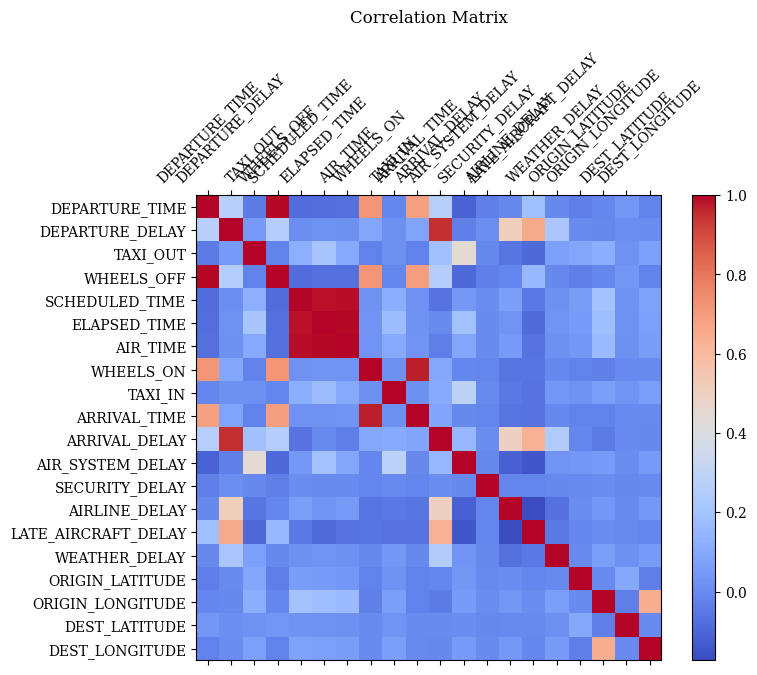

In [18]:
corr_matrix = flights_needed_data.select_dtypes([int, 'float']).corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.matshow(corr_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix", pad=20)
plt.show()

In [19]:
# Set threshold values
target_corr_threshold = 0.2
feature_corr_threshold = 0.8

# Step 1: Select features with high correlation with the target
target_corr = corr_matrix['ARRIVAL_DELAY'].abs()
high_corr_features = target_corr[target_corr > target_corr_threshold].index.tolist()
high_corr_features.remove('ARRIVAL_DELAY')  # Remove the target itself

# Step 2: Filter out highly correlated features among selected features
filtered_features = high_corr_features.copy()
for feature in high_corr_features:
    for other_feature in high_corr_features:
        if feature != other_feature and corr_matrix[feature][other_feature] > feature_corr_threshold:
            if other_feature in filtered_features:
                filtered_features.remove(other_feature)

print("Selected features for model training:", filtered_features)

Selected features for model training: ['DEPARTURE_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


In [ ]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    if contingency_table.size == 0:
        return np.nan 

    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_cols = flights_needed_data.select_dtypes(include=['object', 'category']).columns

cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0 
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(flights_needed_data[col1], flights_needed_data[col2])

print(cramers_v_matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Cramér's V Correlation Matrix for Categorical Columns")
plt.show()

In [ ]:
cramers_v_matrix

In [ ]:
threshold = 0.6

high_association_columns = set()

for col in cramers_v_matrix.columns:
    high_values = cramers_v_matrix[col][cramers_v_matrix[col] > threshold]
    high_association_columns.update(high_values.index)

high_association_columns = list(high_association_columns)
print("Columns with Cramér's V > 0.5 with at least one other column:", high_association_columns)

# Define columns by data type

In [ ]:
##numerical_cols = ['MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
 #                 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
 #                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
##categorical_cols = ['AIRLINE', 'ARRIVAL_TIME_SEGMENT']

numerical_cols = ['SCHEDULED_DEPARTURE', 'DISTANCE','SCHEDULED_ARRIVAL']                
#categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                    'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
categorical_cols = ['ORIGIN_AIRPORT', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT_CODE', 'AIRLINE', 'ORIGIN_CITY', 'DAY', 'DAY_OF_WEEK',
                    'DIVERTED', 'DESTINATION_AIRPORT_CODE', 'CANCELLED', 'MONTH', 'FLY_DATE', 'CANCELLATION_REASON', 'ORIGIN_COUNTRY',
                    'ORIGIN_STATE', 'ARRIVAL_TIME_SEGMENT', 'DEST_COUNTRY', 'DEST_AIRPORT', 'DEST_CITY', 'DEST_STATE',
                    'TAIL_NUMBER', 'AIRLINE__CODE']

# Creating the target column

In [ ]:
# result = []
# for row in flights_needed_data['ARRIVAL_DELAY']:
#   if row > 5:
#     result.append(1)
#   else:
#     result.append(0) 

# flights_needed_data['delay_flag'] = result
# flights_needed_data.value_counts('delay_flag')

In [ ]:
flights_needed_data['MONTH'] = flights_needed_data['MONTH'].astype(int)

In [ ]:
test_data = flights_needed_data[flights_needed_data['MONTH'] > 6] 
#test=test.drop(['FLY_DATE'], axis=1)
train_data = flights_needed_data[flights_needed_data['MONTH'] <= 6]

#train_data  = flights_needed_data[flights_needed_data["MONTH"].apply(lambda x: '11' not in x and '12' not in x)]
#test_data = flights_needed_data[flights_needed_data["MONTH"].apply(lambda x: '11' in x or '12' in x)]

In [ ]:
train_data.shape, test_data.shape

In [ ]:
test_data.info()

In [ ]:
# Replace 'target_column_name' with the actual name of your target column
X_train = train_data.drop(columns=['ARRIVAL_DELAY'])
y_train = train_data['ARRIVAL_DELAY']

# Replace 'target_column_name' with the actual name of your target column
X_test = test_data.drop(columns=['ARRIVAL_DELAY'])
y_test = test_data['ARRIVAL_DELAY']

In [ ]:
X_train.columns

In [ ]:
# numerical_cols = [ 'DISTANCE','AIR_TIME']                
# categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                     'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
# ## should add flytime if rerunning again

In [ ]:
##numerical_cols = ['MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
 #                 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
 #                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
##categorical_cols = ['AIRLINE', 'ARRIVAL_TIME_SEGMENT']

numerical_cols = ['SCHEDULED_DEPARTURE', 'DISTANCE','SCHEDULED_ARRIVAL', 'AIR_TIME']                
#categorical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER','TAIL_NUMBER',
#                    'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'DEST_AIRPORT', 'DEST_CITY','ARRIVAL_TIME_SEGMENT']
categorical_cols = ['ORIGIN_AIRPORT', 'FLIGHT_NUMBER', 'AIRLINE',  'DAY', 'DAY_OF_WEEK', 'MONTH',  'ARRIVAL_TIME_SEGMENT',
                    'DEST_COUNTRY', 'DEST_AIRPORT']

# Define transformations for numerical columns: imputing and scaling

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define transformations for categorical columns: imputing and one-hot encoding


In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both transformations in a ColumnTransformer


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [ ]:
regressors = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'KNeighbors': KNeighborsRegressor(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor()
}

param_grid = {
    'RandomForest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.1, 0.3],
        'regressor__max_depth': [3, 10],
        'regressor__subsample': [0.5, 1.0]
    },
    'Ridge': {
        'regressor__alpha': [1.0, 10.0, 100.0]
    },
    'Lasso': {
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    'ElasticNet': {
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    },
    'LinearRegression': {},  # No hyperparameters to tune
    'DecisionTree': {
        'regressor__max_depth': [5, 10, 15]
    },
    'KNeighbors': {
        'regressor__n_neighbors': [3, 5, 7]
    },
    'SVR': {
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['linear', 'rbf']
    },
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.1, 0.3],
        'regressor__max_depth': [3, 5]
    }
}

# Initialize variables to store the best model and score
best_model = None
best_score = float('-inf')
best_params = None

In [ ]:
for name, regressor in regressors.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Check if this model is the best so far
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    
    print(f"Model: {name}")
    print(f"Best R² score from cross-validation: {grid_search.best_score_}")
    print(f"Best parameters: {grid_search.best_params_}")
    print("")

# Output the best model and its parameters
print("Best model overall:")
print(best_model)
print(f"Best cross-validation R² score: {best_score}")
print(f"Best parameters: {best_params}")

# Evaluate on the test set
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test set MSE: {test_mse}")
print(f"Test set R² score: {test_r2}")

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# pipeline.fit(X_train, y_train)

# y_train_pred = pipeline.predict(X_train)

# train_mse = mean_squared_error(y_train, y_train_pred)
# train_mae = mean_absolute_error(y_train, y_train_pred)
# train_r2 = r2_score(y_train, y_train_pred)

# print(f"Training MSE: {train_mse}")
# print(f"Training MAE: {train_mae}")
# print(f"Training R²: {train_r2}")


# y_test_pred = pipeline.predict(X_test)

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_mae = mean_absolute_error(y_test, y_test_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f"Test MSE: {test_mse}")
# print(f"Test MAE: {test_mae}")
# print(f"Test R²: {test_r2}")


# mse_tolerance = 0.2 

# if train_mse < test_mse * (1 - mse_tolerance) and train_r2 > test_r2:
#     print("The model is likely overfitting.")
# elif train_mse > test_mse * (1 + mse_tolerance):
#     print("The model is likely underfitting.")
# else:
#     print("The model is likely generalizing well.")